Here we gonna run experiment with Transformer-CycleGAN. It gonna be cooool!

First of all, we should use two transformers: src->trg and trg->src. We gonna sample from them and build cyclic loss:
* take two unrelated examples, $x$ from `src` and $y$ from `trg`, translate them: $x \to \hat{y}, y \to \hat{x}$ and then translate them back. The result should be identical to original values: $x \to \hat{y} \to x$ and $y \to \hat{x} \to y$.

We should also try:
* using single Transformer for src->trg and trg->src translation (it is capable to do it in supervised regime)
* adding noise
* adding noise and learning as DAE
* using learnt word embeddings
* using strong discriminator (Transformer or RNN)
* using shared encoder/decoder
* using single discriminator
* adding normalization between two generators
* learning short sentences first and gradually increasing length (cause our time dependencies are way too long)
* try increasing `max_len` over time (or start learning on shorter sentences, aka cirriculum learning): looks like Transformer accounts for target sequence too much during training, that's why we have good training losses and bad BLEU

In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import sys; sys.path += ['..', '../src']

In [3]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'multi30k.train.en.tok')
train_trg_path = os.path.join(DATA_PATH, 'multi30k.train.fr.tok')
val_src_path = os.path.join(DATA_PATH, 'multi30k.val.en.tok')
val_trg_path = os.path.join(DATA_PATH, 'multi30k.val.fr.tok')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

vocab_src = Vocab.from_sequences(train_src)
vocab_trg = Vocab.from_sequences(train_trg)

# Simple preprocessing: crop lines and remove empty sentences
train_src = [s.split()[:max_len-2] for s in train_src if len(s) != 0]
train_trg = [s.split()[:max_len-2] for s in train_trg if len(s) != 0]
val_src = [s.split()[:max_len-2] for s in val_src if len(s) != 0]
val_trg = [s.split()[:max_len-2] for s in val_trg if len(s) != 0]

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [4]:
import os

from src.models import Transformer, TransformerClassifier
from src.utils.data_utils import load_embeddings, init_emb_matrix

transformer_kwargs = {
    'd_word_vec': 256,
    'd_model': 256,
    'd_inner_hid': 1024,
    'd_k': 64,
    'd_v': 64,
    'dropout': 0.1
}
# transformer_kwargs = {
#     'n_layers': 2,
#     'n_head': 2,
#     'd_word_vec': 128,
#     'd_model': 128,
#     'd_inner_hid': 256,
#     'd_k': 32,
#     'd_v': 32
# }

# transformer_src_to_trg = Transformer(len(vocab_src), len(vocab_trg), max_len)
transformer_src_to_trg = Transformer(len(vocab_src), len(vocab_trg), max_len, **transformer_kwargs)
discriminator_trg = TransformerClassifier(len(vocab_trg), 2, max_len, **transformer_kwargs)

# transformer_trg_to_src = Transformer(len(vocab_trg), len(vocab_src), max_len)
transformer_trg_to_src = Transformer(len(vocab_trg), len(vocab_src), max_len, **transformer_kwargs)
discriminator_src = TransformerClassifier(len(vocab_src), 2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
# embeddings_src = load_embeddings('../trained_models/wiki.multi.en.vec')
# embeddings_trg = load_embeddings('../trained_models/wiki.multi.fr.vec')

# init_emb_matrix(transformer_src_to_trg.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
# init_emb_matrix(transformer_src_to_trg.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

# init_emb_matrix(transformer_trg_to_src.encoder.src_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)
# init_emb_matrix(transformer_trg_to_src.decoder.tgt_word_emb.weight.data, embeddings_src, vocab_src.token2id)

# init_emb_matrix(discriminator_src.transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
# init_emb_matrix(discriminator_trg.transformer.encoder.src_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

In [5]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam

from src.dataloaders import Batcher
from src.vocab import constants
from src.trainers import CycleTrainer


training_data = Batcher(train_src_idx, train_trg_idx, vocab_src.token2id,
                        vocab_trg.token2id, batch_size=8, shuffle=False)

val_data = Batcher(val_src_idx[:64], val_trg_idx[:64], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=8, shuffle=False)
    

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)


reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))

transformer_src_to_trg_optimizer = Adam(transformer_src_to_trg.get_trainable_parameters(), lr=1e-4)
transformer_trg_to_src_optimizer = Adam(transformer_trg_to_src.get_trainable_parameters(), lr=1e-4)
discriminator_src_optimizer = Adam(discriminator_src.get_trainable_parameters(), lr=1e-4)
discriminator_trg_optimizer = Adam(discriminator_trg.get_trainable_parameters(), lr=1e-4)

# transformer_src_to_trg_optimizer = Adam([
#     {'params': transformer_src_to_trg.get_trainable_params_without_embs(), 'lr': 1e-4},
#     {'params': transformer_src_to_trg.get_embs_parameters(), 'lr': 1e-5}
# ])
# transformer_trg_to_src_optimizer = Adam([
#     {'params': transformer_trg_to_src.get_trainable_params_without_embs(), 'lr': 1e-4},
#     {'params': transformer_trg_to_src.get_embs_parameters(), 'lr': 1e-5}
# ])


training_config = {
    'max_num_epochs': 100,
    'temperature_update_scheme': (0.001, 0.001, 0),
    
    # We first need generator to become a good LM
    # After that it should learn to preserve content
    'generator_loss_coef_update_scheme': (2, 0.5, 30000),
    'critic_clip_val': 0.1
}

trainer = CycleTrainer(transformer_src_to_trg, transformer_trg_to_src,
                 discriminator_src, discriminator_trg, vocab_src, vocab_trg,
                 transformer_src_to_trg_optimizer, transformer_trg_to_src_optimizer,
                 discriminator_src_optimizer, discriminator_trg_optimizer,
                 reconstruct_src_criterion, reconstruct_trg_criterion, training_config)

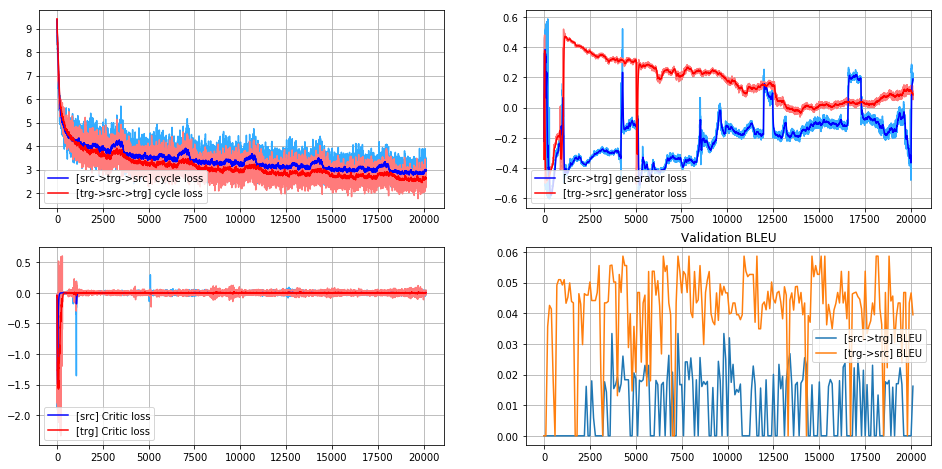

In [6]:
trainer.run_training(training_data, val_data, plot_every=10, val_bleu_every=100)

In [9]:
translation_info = trainer.validate_bleu(val_data, return_translations=True)

In [10]:
translation_info

{'all_targets_src_to_trg': ['Un homme dans un bureau encombré utilise le téléphone',
  'Une femme souriante avec un débardeur pêche est debout , tenant un VTT',
  'Un jeune enfant est debout seul sur des rochers __UNK__ .',
  'Une personne sur une motoneige en plein saut .',
  "Trois jeunes enfants sont debout autour d' un baril bleu et blanc .",
  'Une femme est assise près de son stand de fleurs __UNK__ sur un marché en plein air .',
  'Une femme jouant un morceau sur son violon .',
  "Trois personnes sur deux motocross et un quad roulent dans l' herbe __UNK__ .",
  'Un homme à moitié nu dort dans son fauteuil dehors .',
  'Un groupe de personnes debout devant une cabane sur un parking .',
  'Une jeune femme fait des tapis dans une forêt tropicale',
  "Trois filles font des grimaces , l' une boit un coup tandis qu' elles sont debout dans une rue très fréquentée .",
  'Un homme seul en T-shirt noir , debout au-dessus de la foule dans un bar très fréquenté .',
  'Une femme et un homme 